# Imports

In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
from typing import Tuple
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from PIL import Image
from tqdm import tqdm

# Helping functions

In [2]:
def show_example(img, label):
    print(label)
    plt.imshow(img.permute(1, 2, 0))

In [3]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

In [51]:
def test_model_dim(batches, channels, H, W):
    x = torch.randn((batches, channels, H, W))
    model_test =RegressionNetwork(backbone='resnet18', num_attributes=12, pretrained=True)
    model_test = model_test.to('cuda')
    return model_test(x)

# Variables

In [4]:
batch_size = 32
epochs = 50

In [5]:
to_pil = T.ToPILImage()

# Dataset load

In [6]:
labels_csv_file = pd.read_csv('F:\Projects\Disertatie\Dataset.csv', delimiter=",")
labels_csv_file.head()

,ImageFile,BalacingElements,ColorHarmony,Content,DoF,Light,MotionBlur,Object,Repetition,RuleOfThirds,score,Symmetry,VividColor
0,farm1_333_19438364933_087c8abc60_b.jpg,-0.2,0.2,-0.2,-0.4,0.0,0.0,-0.4,0.0,-0.2,0.30,0.0,0.0
1,farm1_452_19898743300_201156d984_b.jpg,0.2,0.4,0.6,-0.2,0.2,0.0,0.6,0.0,0.8,0.70,0.0,0.4
2,farm1_281_20247100976_c8141d3653_b.jpg,-0.2,0.0,0.4,-0.2,-0.4,0.0,-0.6,0.0,-0.4,0.40,0.0,0.6
3,farm1_448_19709457333_be4c6bb5eb_b.jpg,0.0,0.6,-0.6,-0.2,0.0,0.0,0.2,0.2,0.0,0.60,0.0,0.4
4,farm1_393_20179744375_c119001350_b.jpg,-0.2,0.6,0.4,0.0,-0.4,0.0,0.2,0.0,0.0,0.45,0.0,0.2


In [7]:
image_dir = 'F:\Projects\Disertatie\ImageAesthetics_ECCV2016\datasetImages_warp256'
label_csv_path = 'F:\Projects\Disertatie\\'

# Instantiate AADB class

In [8]:
class AADB(Dataset):

    attributes = [
        "balancing_elements",
        "color_harmony",
        "content",
        "depth_of_field",
        "light",
        "motion_blur",
        "object",
        "repetition",
        "rule_of_thirds",
        "symmetry",
        "vivid_color",
        "score"
    ]
    
    def __init__(self, image_dir, label_csv_path, test=False):
        self.label_csv_path = label_csv_path
        self.image_dir = image_dir
        self.test=test
        self.transform = T.Compose([T.Resize(size=(256, 256)), T.ToTensor()])
        self.files, self.labels = self.load_data(self.image_dir, self.label_csv_path, self.test)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image = Image.open(self.files[index]).convert("RGB")
#         print("Image Name: {}".format(self.files[index].split("/")[-1]))
        image = self.transform(image)
        label = torch.from_numpy(self.labels[index])
        return image, label

    def load_data(self, image_dir, csv_path, test=False):
        csv_file = csv_path + 'Dataset.csv' if not test else csv_path + 'Dataset_test.csv'
        label_csv = pd.read_csv(csv_file, delimiter=",")
        files = [os.path.join(image_dir, f) for f in label_csv['ImageFile']]
#         labels = np.asarray([label.values for index, label in label_csv.drop(['ImageFile'], axis=1).iterrows()])
        labels = []
        for index, label in label_csv.drop(['ImageFile'], axis=1).iterrows():  # this is for moving score to the last value
            label = list(label.values)
            label.append(label.pop(9))
            labels.append(label)
            
        labels = np.asarray(labels)
        return files, labels

In [9]:
aadb = AADB(image_dir, label_csv_path)
aadb_test = AADB(image_dir, label_csv_path, test=True)

tensor([-0.2000,  0.2000, -0.2000, -0.4000,  0.0000,  0.0000, -0.4000,  0.0000,
        -0.2000,  0.0000,  0.0000,  0.3000], dtype=torch.float64)


8958

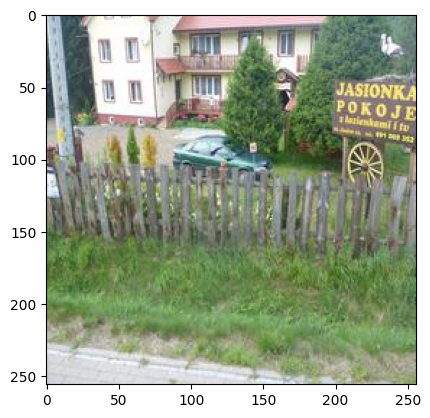

In [13]:
show_example(*aadb[0])
len(aadb)

tensor([ 0.0000,  0.8000,  0.6000,  0.6000, -0.2000,  0.0000,  0.8000,  0.0000,
         0.0000,  0.0000, -0.2000,  0.6500], dtype=torch.float64)


1000

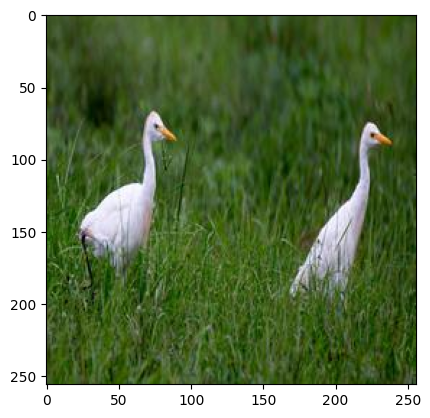

In [14]:
show_example(*aadb_test[0])
len(aadb_test)

# Initiate DataLoaders

In [15]:
val_size = 500
train_size = len(aadb) - val_size

train_ds, val_ds = random_split(aadb, [train_size, val_size])
len(train_ds), len(val_ds)

(8458, 500)

In [16]:
train_dl = DataLoader(train_ds, batch_size*2, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
valid_dl = DataLoader(val_ds, batch_size, num_workers=0, pin_memory=True)

In [17]:
print(len(train_dl))
print(len(valid_dl))

132
16


In [50]:
for image, _ in train_dl:
    print(image.shape)
    break

torch.Size([64, 3, 256, 256])


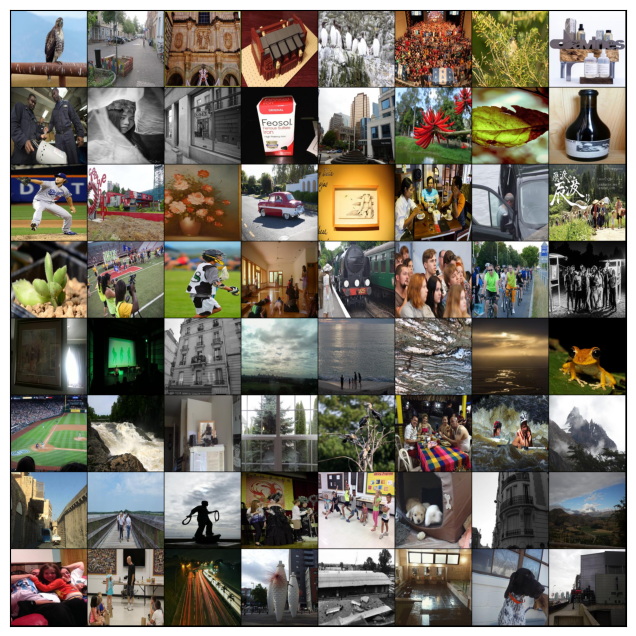

In [18]:
show_batch(train_dl)

# Using GPU

In [19]:
def get_default_device():
    '''Pick GPU if available'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    '''Move tensors to chosen device'''
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True).to(torch.float32)

In [20]:
class DeviceDataLoader():
    def __init__(self, dl ,device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [23]:
print(len(train_dl))
print(len(valid_dl))

132
16


# Function Losses

In [24]:
class RankLoss(nn.Module):

    def __init__(self, margin):
        super().__init__()
        self.margin = margin

    def forward(self,
        y_pred: Tuple[torch.Tensor, torch.Tensor],
        y_true: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:

        device, dtype = y_pred[0].device, y_pred[0].dtype

        target = torch.ones_like(y_true[0]).to(device).to(dtype)

        # Set indices where y_true1 < y_true2 to -1
        target[y_true[0] < y_true[1]] = -1.0

        return F.margin_ranking_loss(
            y_pred[0],
            y_pred[1],
            target,
            margin=self.margin
        )


class RegRankLoss(nn.Module):

    def __init__(self, margin: float):
        super().__init__()
        self.reg_loss = nn.MSELoss(reduction="mean")
        self.rank_loss = RankLoss(margin)

    def forward(self,
        y_pred: Tuple[torch.Tensor, torch.Tensor],
        y_true: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        
        loss_reg = (
            self.reg_loss(y_pred[0], y_true[0]) +
            self.reg_loss(y_pred[1], y_true[1])
        ) / 2.0

        loss_rank = self.rank_loss(y_pred, y_true)
        loss = loss_reg + loss_rank
        return loss, loss_reg, loss_rank

In [25]:
loss_fn = RegRankLoss(margin=0.02)

# Model

In [26]:
class Backbone(nn.Module):

    def __init__(self, backbone, pretrained):
        super().__init__()
        resnet = getattr(torchvision.models, backbone)(pretrained=pretrained)
        self.num_features = resnet.fc.in_features
        self.model = nn.Sequential(*list(resnet.children())[:-1])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x).squeeze()


class RegressionNetwork(nn.Module):

    def __init__(self, backbone, num_attributes, pretrained):
        super().__init__()
        backbone = Backbone(backbone, pretrained)
        self.model = nn.Sequential(
            backbone,
            nn.Linear(
                in_features=backbone.num_features,
                out_features=num_attributes
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [27]:
model = RegressionNetwork(backbone='resnet18', num_attributes=12, pretrained=True)
model = model.to('cuda')

F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training Model

In [29]:
train_losses = []
train_losses_reg = []
train_losses_rank = []
val_losses = []

In [31]:
opt = torch.optim.SGD(params=model.parameters(), lr=0.0001, momentum=0.9)

for epoch in range(epochs):
    
    # Training Phase
    model.train()
    
    pbar = tqdm(enumerate(train_dl), total=len(train_dl))
    for batch, (x, y) in pbar:
        
        opt.zero_grad()
        x1, x2 = torch.split(x, 32, dim=0)
        y1, y2 = torch.split(y, 32, dim=0)

        y_pred1 = model(x1)
        y_pred2 = model(x2)
        loss, loss_reg, loss_rank = loss_fn(y_pred=(y_pred1, y_pred2),y_true=(y1, y2))
        loss.backward()
        opt.step()

        pbar.set_description("Epoch {}, Reg Loss: {:.4f}, Rank Loss: {:.4f} ".format(
            epoch, float(loss_reg), float(loss_rank)))
    train_losses.append(loss)   
    train_losses_reg.append(loss_reg)
    train_losses_rank.append(loss_rank)
        
    
    # Evaluation Phase
    model.eval()
    test_loss = 0.0 
    pbar = tqdm(enumerate(valid_dl), total=len(valid_dl))
    for batch, (x, y) in pbar:
        
        with torch.no_grad():
            y_pred = model(x)
            test_loss += F.mse_loss(y_pred, y)
            
    test_loss /= len(valid_dl)
    val_losses.append(test_loss)
    filename = "{}_epoch_{}_loss_{:.4f}_.pt".format('AADB', epoch, test_loss)
    torch.save(model.state_dict(), os.path.join('F:\Projects\Disertatie\model_saves', filename))
    
        
        

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 32.58it/s]


# Evaluation

In [28]:
model = RegressionNetwork(backbone='resnet18', num_attributes=12, pretrained=True)
model = model.to('cuda')
model.load_state_dict(torch.load("F:\Projects\Disertatie\model_saves\AADB_epoch_49_loss_0.0701_.pt"))
model.eval()

F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RegressionNetwork(
  (model): Sequential(
    (0): Backbone(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [29]:
test_dl = DataLoader(aadb_test, batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
test_dl = DeviceDataLoader(test_dl, device)

In [30]:
loss = 0.0 
y_preds = []
with torch.no_grad():
    for batch, (x, y) in tqdm(enumerate(test_dl), total=len(test_dl)):
        y_pred = model(x)
        loss += F.mse_loss(y_pred, y)
        y_preds.append(y_pred)
    
    loss /= len(test_dl)
    y_preds = torch.cat(y_preds, dim=0).cpu().numpy()
    y_preds = np.clip(y_preds, -1.0, 1.0)
    y_preds = np.array([list(np.around(np.array(i), 3)) for i in y_preds])
    
    print("Test Loss: {:.4f}".format(float(loss)))

100%|██████████| 32/32 [00:03<00:00,  8.23it/s]


Test Loss: 0.0809


# Results

In [55]:
def plot_loss(train_losses, val_losses):
    train_losses_list = [i.item() for i in train_losses]
    val_losses_list = [i.item() for i in val_losses]
    plt.plot(train_losses_list, '-bx')
    plt.plot(val_losses_list, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs No. of epochs');
    

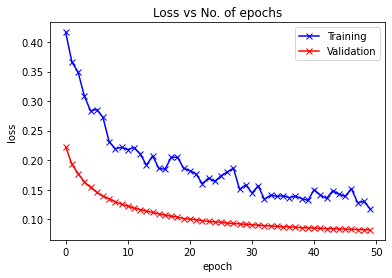

In [56]:
plot_loss(train_losses, val_losses)

In [31]:
pos = 0.2  
neg = -0.2 

C:\Users\bogma\AppData\Local\Temp\ipykernel_26592\3040588036.py:30: MatplotlibDeprecationWarning: The rectangles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Any custom property styling may be lost.
  [rec.set_facecolor(choices[c]) for rec, c in zip(checkboxes_true.rectangles, colors)]
C:\Users\bogma\AppData\Local\Temp\ipykernel_26592\3040588036.py:45: MatplotlibDeprecationWarning: The rectangles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Any custom property styling may be lost.
  [rec.set_facecolor(choices[c]) for rec, c in zip(checkboxes_true.rectangles, colors)]


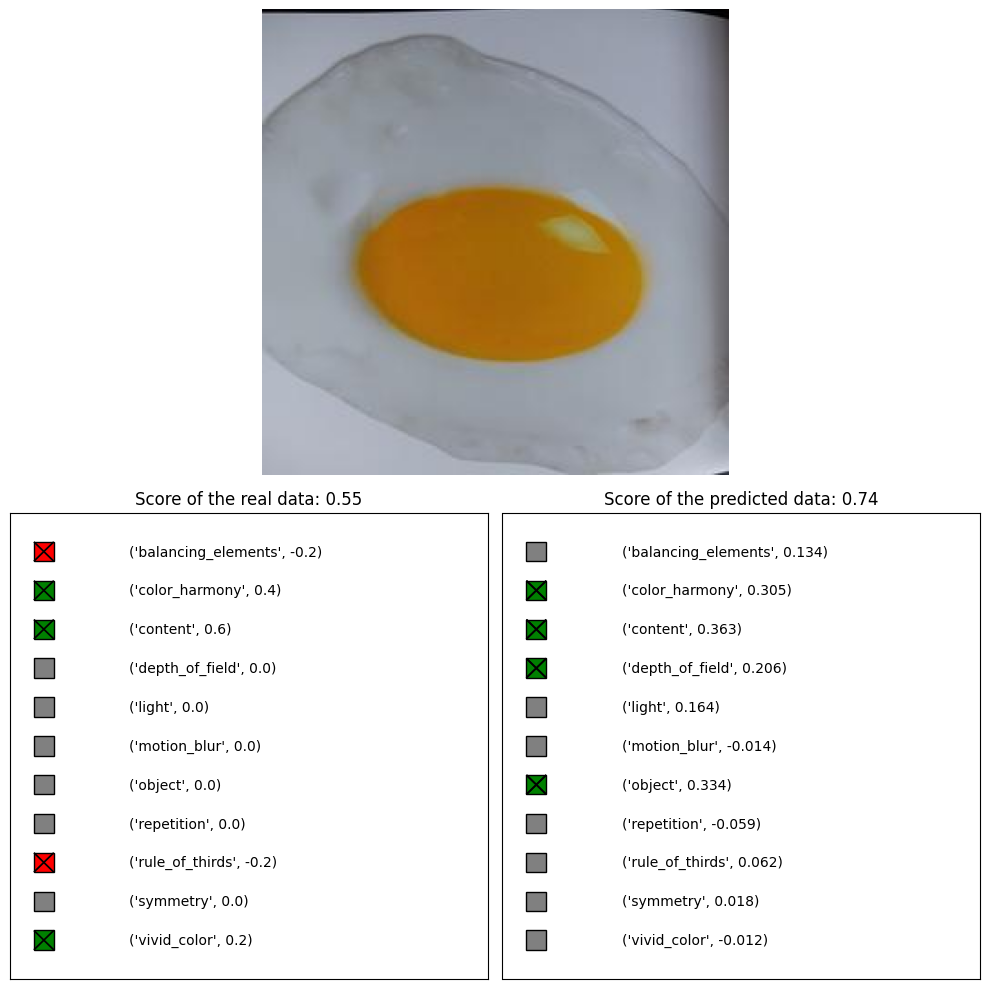

In [44]:
i = random.randint(0, len(aadb_test))
x, y = aadb[i]
y = y.numpy()
y_pred = y_preds[i]

# Initiate figure
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

# Picture
ax0.imshow(to_pil(x))
ax0.set_axis_off()

# True results
ax1.set_title("Score of the real data: {:.2f}".format(y[-1]))
states = np.zeros_like(y[:-1], dtype=bool)
states[y[:-1] >= pos] = True
states[y[:-1] <= neg] = True

value_tag = [(v, t) for v, t in zip(aadb_test.attributes[:-1], y[:-1])]
checkboxes_true = mpl.widgets.CheckButtons(ax1, value_tag, actives=states)

choices = {0: "gray", -1:"red", 1:"green"}
colors = np.zeros_like(y[:-1], dtype=int)
colors[y[:-1] >= pos] = 1
colors[y[:-1] <= neg] = -1
[rec.set_facecolor(choices[c]) for rec, c in zip(checkboxes_true.rectangles, colors)]

# Predicted Results
ax2.set_title("Score of the predicted data: {:.2f}".format(y_pred[-1]))
states = np.zeros_like(y_pred[:-1], dtype=bool)
states[y_pred[:-1] >= pos] = True
states[y_pred[:-1] <= neg] = True

value_tag = [(v, t) for v, t in zip(aadb_test.attributes[:-1], y_pred[:-1])]
checkboxes_true = mpl.widgets.CheckButtons(ax2, value_tag, actives=states)

choices = {0: "gray", -1:"red", 1:"green"}
colors = np.zeros_like(y_pred[:-1], dtype=int)
colors[y_pred[:-1] >= pos] = 1
colors[y_pred[:-1] <= neg] = -1
[rec.set_facecolor(choices[c]) for rec, c in zip(checkboxes_true.rectangles, colors)]

# Plot
plt.tight_layout()
plt.show()